In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from glob import glob
import os
pbar = ProgressBar()
pbar.register()

from tqdm import tqdm_notebook as tqdm
import geopandas as gpd

#한글깨짐 방지
plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

### data load
통합파일 저장시, index = False조건을 안해놈.. 나중 수정..

In [2]:
s_2017 = pd.read_csv('E:/python/data/신한카드데이터/내국인 성별연령별_2017년_신한_종합.csv').iloc[:,1:]
s_2016 = pd.read_csv('E:/python/data/신한카드데이터/내국인 성별연령별_2016년_신한_종합.csv').iloc[:,1:]
gu = gpd.read_file('E:/python/data/1. 공통참조파일/1. 지역경계 shp파일/통계청/2016년/서울시(집계구)_EPSG_5179.shp',
                  encoding = 'cp949')

### 집계구 광진구만 발라내고 결합

In [3]:
def gu_merge(df):
    #집계구 코드 불러오고 발라내기 
    gwang_code = pd.read_csv('./data/광진구_행정동코드.csv',encoding = 'cp949')
    gwangjin_dong = gwang_code['행정동'].values
    gwangjin_gu = gu[gu.ADM_NM.isin(gwangjin_dong)]

    # 각 집계구의 중심점
    gwangjin_gu['center_point'] = gwangjin_gu.geometry.apply(lambda x : x.centroid)
    gwangjin_gu['center_x'] = gwangjin_gu.center_point.apply(lambda point : point.x)
    gwangjin_gu['center_y'] = gwangjin_gu.center_point.apply(lambda point : point.y)
    
    #데이터 결합
    df.BLOCK_ID = df.BLOCK_ID.astype(str) #타입이 다르므로 통일
    merged = gwangjin_gu.merge(df, how = 'outer',left_on = 'TOT_REG_CD',right_on = 'BLOCK_ID')
    
    #결측제외 (집계구 개수와, 데이터의 집계구 개수가 다름)
    merged = merged[~(merged.BLOCK_ID.isna())]
    return merged

In [ ]:
s_2017_gu = gu_merge(s_2017)
s_2016_gu = gu_merge(s_2016)

In [5]:
def near_park(df):
    ''' 어린이 대공원 주변으로 범위내 축소 
    '''
    # 대공원주변 범위
    ymin,ymax = 1949300, 1951100
    xmin,xmax = 962000, 964100
    
    target = df[(df.center_x >= xmin)&(df.center_x <= xmax)]
    target = target[(target.center_y >= ymin)&(target.center_y <= ymax)]
    
    #건대상권 제외
    gun_x, gun_y = 962250, 1949600
    target = target[~((target.center_x <= gun_x)&((target.center_y <= gun_y)))]
    
    return target

In [6]:
near_2016 = near_park(s_2016_gu)
near_2017 = near_park(s_2017_gu)

In [7]:
def labeling(df):
    '''BLOCK_ID값으로 label매칭
    '''
    label = pd.read_csv('./data/신한카드데이터/블럭별 클러스터라벨.csv')
    label['BLOCK_ID'] = label.BLOCK_ID.astype(str)
    labeled = pd.merge(df, label,how= 'left',on = 'BLOCK_ID')
    return labeled

In [8]:
near_2016_lb = labeling(near_2016)
near_2017_lb = labeling(near_2017)

In [15]:
#주말값 추가 
def add_weekend(df):
    #주말구분
    df.loc[(df.DAW_CCD == 1)|(df.DAW_CCD == 7),'weekend'] = "1"
    df.loc[~((df.DAW_CCD == 1)|(df.DAW_CCD == 7)),'weekend'] = "0"
    return df

In [16]:
near_2016_lb = add_weekend(near_2016_lb)
near_2017_lb = add_weekend(near_2017_lb)

In [9]:
### 좌표 데이터 기억
geo_2017 = near_2016_lb[['BLOCK_ID','geometry']]
geo_2016 = near_2017_lb[['BLOCK_ID','geometry']]

geo_2017 = geo_2017.drop_duplicates()
geo_2016 = geo_2016.drop_duplicates()

geo_m = pd.concat([geo_2017,geo_2016])
geo_m = geo_m.drop_duplicates().reset_index(drop = True)

### codebook

In [10]:
#key값지정
code_book = {}
code_book[1] = "20세이하"
code_book[2] = "21~30세"
code_book[3] = "31~40세"
code_book[4] = "41~50세"
code_book[5] = "51~60세"
code_book[6] = "61세이상"
code_book['t1'] = "00시00~05시59"
code_book['t2'] = "06시00~11시59"
code_book['t3'] = "12시00~17시59"
code_book['t4'] = "18시00~23시59"
code_book['F'] = "여성"
code_book['M'] = "남성"
code_book["1"] = "주말"
code_book["0"] = "주중"
#컬럼명
code_book['USECT_CORR'] = "평균 이용건수"
code_book['AMT_CORR'] = "평균 이용금액"
code_book['C_PER_AMT'] = "건별 평균 이용금액"
code_book['AGE_GB'] = "연령대"
code_book['weekend'] = "주말"
code_book['SEX_CCD'] = "성별"
code_book['TM'] = "시간대"
code_book['SB_UPJONG'] = '업종'

#업종추가
upjong = pd.read_csv('./data/041. 서울시 15-17년 업종별 내외국인 신한카드 매출데이터/2. 파일데이터/신한카드_내국인_업종코드.csv',
                    encoding= 'cp949')
upjong['UPJONG_NM'] = upjong['UPJONG_NM'].apply(lambda x : x.replace('/','&')) 
upjong.index = upjong.UPJONG
del upjong['UPJONG']
upjong_dict = upjong.to_dict()
upjong_dict = upjong_dict['UPJONG_NM']
code_book.update(upjong_dict)

### 개별그래프

In [941]:
#그냥 그림 쭉쭉뽑는거
def col_monthly_n(df,target_col):
    '''
    특정컬럼별/ 평균 이용건수 및 평균 이용금액 
    '''
    # 저장할 위치
    os.makedirs('./output/신한카드/', exist_ok=True)
    # 연도
    year = df['TS_YM'].astype(str)[0][:4]
    if year == 2016:
        divid = 12
    else:
        divid = 11
    grouped = (df.groupby(['BLOCK_ID',target_col])['USECT_CORR','AMT_CORR'].sum()/divid).reset_index()
    grouped = pd.merge(grouped,geo_m)
    grouped = gpd.GeoDataFrame(grouped)
    
    #건별 평균 이용금액
    grouped['C_PER_AMT'] = round(grouped['AMT_CORR']/grouped['USECT_CORR'],2)

    #시간대별 매출액
    target_col_values = grouped[target_col].unique()
#     cols = ['C_PER_AMT']
    cols = ['USECT_CORR','AMT_CORR','C_PER_AMT']

    for t_c in target_col_values:
        for col in cols: 
            target = grouped[grouped[target_col] == t_c]
            fig,ax = plt.subplots(1,1,figsize = (15,15))
            target.plot(column = col,ax = ax,edgecolor = 'black',cmap = 'OrRd',legend = True)
            plt.title(f'{code_book[t_c]}_{code_book[col]}')
            plt.axis('off')
            # 파일저장 예) 2016_평균이용건수_20세 이하
            plt.savefig(f'./output/신한카드/{year}_{code_book[col]}_{code_book[t_c]}.png')
            plt.close()
#     return grouped

In [768]:
#시간대별
for file in [near_2016_lb,near_2017_lb]:
    for col in ['TM','AGE_GB','SEX_CCD','SB_UPJONG','weekend']:
        col_monthly_n(file,col)

In [943]:
#subplot으로 종합해서 그리기
def col_monthly(df, target_col, nrow,ncol):
    '''
    특정컬럼별/ 평균 이용건수 및 평균 이용금액 
    '''
    #저장할 위치
    os.makedirs('./output/신한카드/', exist_ok=True)
    
    # 연도
    year = df['TS_YM'].astype(str)[0][:4]
    if year == 2016:
        divid = 12
    else:
        divid = 11
    grouped = (df.groupby(['BLOCK_ID',target_col])['USECT_CORR','AMT_CORR'].sum()/divid).reset_index()
    grouped = pd.merge(grouped,geo_m)
    grouped = gpd.GeoDataFrame(grouped)
    
    #순서지정 count
    c = 0
    
    #건별 평균 이용금액
    grouped['C_PER_AMT'] = round(grouped['AMT_CORR']/grouped['USECT_CORR'],2)
    
    #이용건수, 이용금액,건당 매출에 관해 3개의 파일 생성
    t_c = grouped[target_col].unique()
    cols = ['USECT_CORR','AMT_CORR','C_PER_AMT']

    for col in cols: 
        fig,axes = plt.subplots(nrow,ncol,figsize = (15,15), 
                                constrained_layout = True,
                                sharex = True, sharey = True)
        #행렬에 따른 그래프 생성
        if nrow >1:
            for i in range(nrow):
                for m in range(ncol):
                    target = grouped[grouped[target_col] == t_c[c]]
                    target.plot(column = col,ax = axes[i][m],edgecolor = 'black',cmap = 'OrRd')                 
                    axes[i][m].set_title(f'{code_book[t_c[c]]}_{code_book[col]}')
                    axes[i][m].axis('off')
                    #각각의 color bar생성
                    patch_col = axes[i][m].collections[0]
                    cb = fig.colorbar(patch_col, ax = axes[i][m], shrink = 0.5)

                    #count up 
                    c += 1   
                    #업종용
                    length = 22
                    if c>length-1:
                        c= length-1
            #리셋
            c = 0
        else :
            for m in range(ncol):
                target = grouped[grouped[target_col] == t_c[c]]
                target.plot(column = col,ax = axes[m],edgecolor = 'black',cmap = 'OrRd')
                axes[m].set_title(f'{code_book[t_c[c]]} {code_book[col]}')
                axes[m].axis('off')
                #각각의 color bar생성
                patch_col = axes[m].collections[0]
                cb = fig.colorbar(patch_col, ax = axes[m], shrink = 0.5)

                #count up
                c += 1 

            #리셋
            c = 0

        # 파일저장 예) 2016_평균이용건수_20세 이하
        plt.savefig(f'./output/신한카드/{year}_{code_book[col]}_{code_book[target_col]}.png')
        plt.close()
    return grouped

In [773]:
#시간대별
time_g_2016_w = col_monthly(near_2016_lb,'TM', nrow =2, ncol = 2)
time_g_2017_w = col_monthly(near_2017_lb,'TM', nrow =2, ncol = 2)

In [774]:
#연령대별 
age_g_2016_w = col_monthly(near_2016_lb,'AGE_GB', nrow =3, ncol = 2)
age_g_2017_w = col_monthly(near_2017_lb,'AGE_GB', nrow =3, ncol = 2)

In [944]:
#성별 
sex_g_2016_w = col_monthly(near_2016_lb,'SEX_CCD', nrow =1, ncol = 2)
sex_g_2017_w = col_monthly(near_2017_lb,'SEX_CCD', nrow =1, ncol = 2)

In [ ]:
#주말
sex_g_2016_w = col_monthly(near_2016_lb,'weekend', nrow =1, ncol = 2)
sex_g_2017_w = col_monthly(near_2017_lb,'weekend', nrow =1, ncol = 2)

In [776]:
#업종별
sex_g_2016_w = col_monthly(near_2016_lb,'SB_UPJONG', nrow =6, ncol = 4)
sex_g_2017_w = col_monthly(near_2017_lb,'SB_UPJONG', nrow =6, ncol = 4)

### 멀티조합
성별-연령 조합이라던가 

In [188]:
#그냥 그림 쭉쭉뽑는거
def col_monthly_add_n(df,col, add_col):
    '''
    특정 컬럼으로 / 평균 이용건수 및 평균 이용금액+ 주말구분
    '''
    year = df['TS_YM'].astype(str)[0][:4]
    ##저장할 위치
    os.makedirs('./output/신한카드/', exist_ok=True)
    
    if year == 2016:
        divid = 12
    else:
        divid = 11
        
    #주말구분
    grouped = (df.groupby(['BLOCK_ID','weekend',col,add_col])['USECT_CORR','AMT_CORR'].sum()/divid).reset_index()
    grouped = pd.merge(grouped,geo_m)
    grouped = gpd.GeoDataFrame(grouped)
        
    #순서지정 count
    c = 0
    
    #건별 평균 이용금액
    grouped['C_PER_AMT'] = round(grouped['AMT_CORR']/grouped['USECT_CORR'],2)
    
    #시간대별 매출액
    target_col_values = grouped[col].unique()
    value_cols = ['USECT_CORR','AMT_CORR','C_PER_AMT']

    for ac in grouped[add_col].unique():
        for t_c in target_col_values:
            for vc in value_cols: 
                target = grouped[grouped[add_col] == ac]       
                target = grouped[grouped[col] == t_c]
                fig,ax = plt.subplots(1,1,figsize = (15,15))
                target.plot(column = vc,ax = ax,edgecolor = 'black',cmap = 'OrRd',legend = True)
                plt.title(f'{code_book[ac]}_{code_book[t_c]}_{code_book[vc]}')
                plt.axis('off')
                # 파일저장 예) 2016_평균이용건수_20세 이하
                plt.savefig(f'./output/신한카드/{year}_{code_book[ac]}_{code_book[vc]}_{code_book[t_c]}.png')
                plt.close()
#     return grouped

In [ ]:
from itertools import combinations
col_set = list(combinations(['TM','AGE_GB','SEX_CCD','SB_UPJONG','weekend'],2))

In [ ]:
#모든 조합
for file in [near_2016_lb,near_2017_lb]:
    for col1, col2 in col_set:
        col_monthly_n(file,col1,col2)

In [215]:
## subplot(미완) - 값이 없을때 대처가 없음
def col_monthly_add(df,col, add_col, nrow,ncol):
    '''
    add_col(str) : 그림을 구분지어줄 컬럼명 (그림의 개수 )
    col(str) : 컬명내 고유값만큼 그림을 그림 (그래프개수) 
    특정 컬럼으로 / 평균 이용건수 및 평균 이용금액
    '''
    year = df['TS_YM'].astype(str)[0][:4]
    ##저장할 위치
    os.makedirs('./output/신한카드/', exist_ok=True)
    
    #방식차이 
    if year == 2016:
        divid = 12
    else:
        divid = 11
    grouped = (df.groupby(['BLOCK_ID','weekend',col,add_col])['USECT_CORR','AMT_CORR'].sum()/divid).reset_index()
    grouped = pd.merge(grouped,geo_m)
    grouped = gpd.GeoDataFrame(grouped)
 
    #순서지정 count
    c = 0
    
    #건별 평균 이용금액
    grouped['C_PER_AMT'] = round(grouped['AMT_CORR']/grouped['USECT_CORR'],2)
    
    #컬럼지정
    t_c = grouped[col].unique()
    value_cols = ['USECT_CORR','AMT_CORR','C_PER_AMT']
    #이용건수, 이용금액에 관해 2개의 파일 생성
    for vc in value_cols: 
        #구분컬럼
        for ac in grouped[add_col].unique():
            fig,axes = plt.subplots(nrow,ncol,figsize = (25,25), 
                                    constrained_layout = True,
                                    sharex = True, sharey = True)
            if nrow >1:
            #행렬에 따른 그래프 생성
                for i in range(nrow):
                    for m in range(ncol):
                        target = grouped[grouped[add_col] == ac]
                        target = target[target[col] == t_c[c]]
                        target.plot(column = vc,ax = axes[i][m],edgecolor = 'black',cmap = 'OrRd')
                        axes[i][m].set_title(f'{code_book[ac]}_{code_book[t_c[c]]}_{code_book[vc]}')
                        axes[i][m].axis('off')
                        #각각의 color bar생성
                        patch_col = axes[i][m].collections[0]
                        cb = fig.colorbar(patch_col, ax = axes[i][m], shrink = 0.5)

                        #count up 
                        c += 1   
                        #업종용으로 임시 사용
                        if col == 'SB_UPJONG':
                            length = 22
                            if c>length-1:
                                c= length-1
                #리셋
                c = 0
                
            else :
                for m in range(ncol):
                    target = grouped[grouped[add_col] == ac]
                    target = target[target[col] == t_c[c]]
                    target.plot(column = vc,ax = axes[m],edgecolor = 'black',cmap = 'OrRd')
                    axes[m].set_title(f'{year}_{code_book[ac]}_{code_book[t_c[c]]}_{code_book[vc]}')
                    axes[m].axis('off')
                    #각각의 color bar생성
                    patch_col = axes[m].collections[0]
                    cb = fig.colorbar(patch_col, ax = axes[m], shrink = 0.5)

                    #count up
                    c += 1 
                                
                #리셋
                c = 0
            # 파일저장 예) 2016_평균이용건수_20세 이하
            plt.savefig(f'./output/신한카드/{year}_{code_book[ac]}_{code_book[col]}_{code_book[vc]}.png')
            plt.close()
    return grouped

In [783]:
#주말 시간
time_g_2016_w = col_monthly_weekend(near_2016_lb,'TM', 'weekend', nrow =2, ncol = 2)
time_g_2017_w = col_monthly_weekend(near_2017_lb,'TM', 'weekend', nrow =2, ncol = 2)

In [784]:
#주말 연령
sex_g_2016_w = col_monthly_weekend(near_2016_lb,'AGE_GB', "weekend", nrow =3, ncol = 2)
sex_g_2017_w = col_monthly_weekend(near_2017_lb,'AGE_GB', "weekend", nrow =3, ncol = 2)

In [948]:
#주말 성별 
sex_g_2016_w = col_monthly_weekend(near_2016_lb,'SEX_CCD', 'weekend', nrow =1, ncol = 2)
sex_g_2017_w = col_monthly_weekend(near_2017_lb,'SEX_CCD', 'weekend', ,nrow =1, ncol = 2)

In [154]:
%%time
#주말 업종 
upjong_g_2016_w = col_monthly_weekend(near_2016_lb,'SB_UPJONG', 'weekend', nrow =6, ncol = 4)
upjong_g_2017_w = col_monthly_weekend(near_2017_lb,'SB_UPJONG', 'weekend', nrow =6, ncol = 4)

Wall time: 6min 37s


C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


IndexError: list index out of range

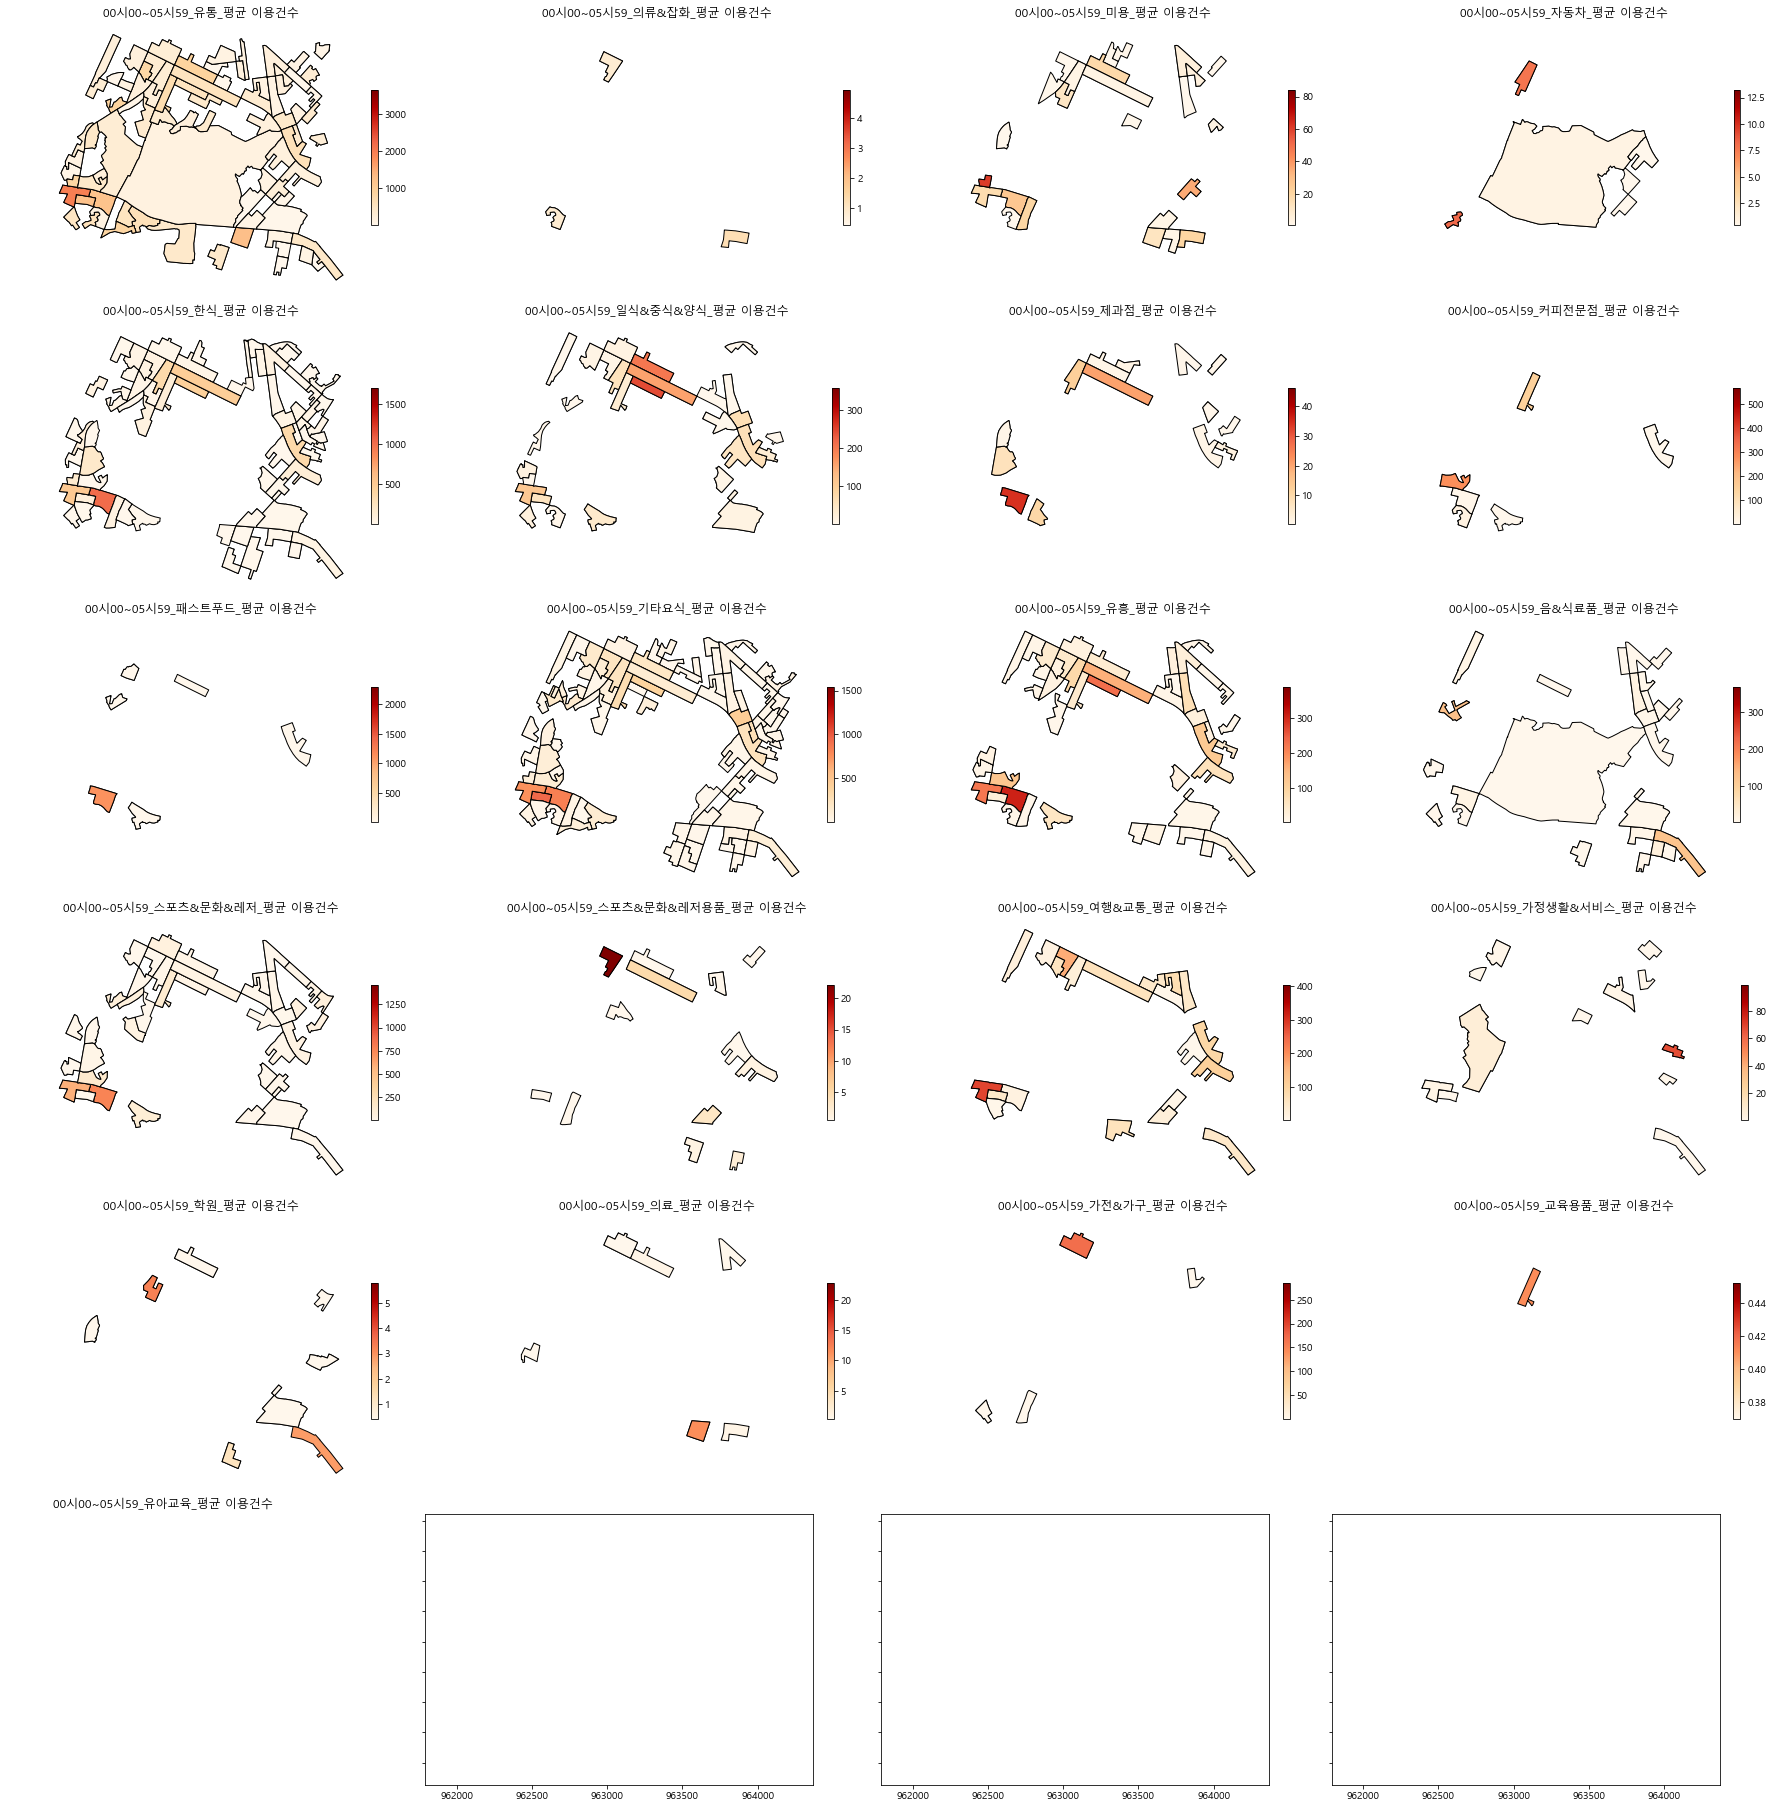

In [214]:
#시간대별 업종
time_g_2016_w = col_monthly_add(near_2016_lb,'SB_UPJONG', 'TM',nrow =5, ncol = 4)
time_g_2017_w = col_monthly_add(near_2017_lb,'SB_UPJONG', 'TM',nrow =5, ncol = 4)

In [ ]:
#성별 업종
time_g_2016_w = col_monthly_add(near_2016_lb,'SB_UPJONG', 'SEX_CCD',nrow =6, ncol = 4)
time_g_2017_w = col_monthly_add(near_2017_lb,'SB_UPJONG', 'SEX_CCD',nrow =6, ncol = 4)

In [207]:
#성별 시간대
time_g_2016_w = col_monthly_add(near_2016_lb,'TM', 'SEX_CCD',nrow =2, ncol = 2)
time_g_2017_w = col_monthly_add(near_2017_lb,'TM', 'SEX_CCD',nrow =2, ncol = 2)

In [211]:
#시간대 연령
sex_g_2016_w = col_monthly_add(near_2016_lb,'AGE_GB', "TM", nrow =3, ncol = 2)
sex_g_2017_w = col_monthly_add(near_2017_lb,'AGE_GB', "TM", nrow =3, ncol = 2)

In [210]:
#성별 연령
sex_g_2016_w = col_monthly_add(near_2016_lb,'AGE_GB', "SEX_CCD", nrow =3, ncol = 2)
sex_g_2017_w = col_monthly_add(near_2017_lb,'AGE_GB', "SEX_CCD", nrow =3, ncol = 2)

### 클러스터별 그래프

In [11]:
#11개 구역 클러스터링 한 내역
label_line = gpd.read_file('E:/python/data/신한카드데이터/라벨별_명칭_geo값.shp')

In [12]:
def agg_cluster(df):
    #11개 구역 클러스터링 한 내역
    label_line = gpd.read_file('E:/python/data/신한카드데이터/라벨별_명칭_geo값.shp')
    
    cluster_df = df[['SB_UPJONG','TS_YM','TM','SEX_CCD','AGE_GB','labels','weekend','USECT_CORR','AMT_CORR']]
    cluster_g = cluster_df.groupby(['SB_UPJONG','TS_YM','TM','SEX_CCD','AGE_GB','labels','weekend'])['USECT_CORR','AMT_CORR'].sum().reset_index()
    cluster_g = cluster_g.merge(label_line, how= 'left')
    cluster_g = gpd.GeoDataFrame(cluster_g)
    
    return cluster_g

In [17]:
c_2016 = agg_cluster(near_2016_lb)
c_2017 = agg_cluster(near_2017_lb)

In [894]:
#월별 line plot
def nomal_axis(df):
    year = df['TS_YM'].astype(str)[0][:4]

    group_cols = ['TS_YM','names']
    df_grouped = df.groupby(group_cols)['USECT_CORR','AMT_CORR'].sum().reset_index()

    df_grouped['MONTH'] = df_grouped['TS_YM'].astype(str).apply(lambda x: int(x[4:6]))
    df_grouped['C_PER_AMT'] = df_grouped['AMT_CORR']/df_grouped['USECT_CORR']

    #매출건수
    plt.figure(figsize= (13,10))
    sns.lineplot(x = 'MONTH',y = 'USECT_CORR', hue = 'names', palette = 'tab20', data = df_grouped)
    plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5),fontsize = 15)
    plt.title(f'{year}_주변상권의 매출건수',fontsize= 15)
    plt.yticks(fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.tight_layout()
    plt.savefig(f'./output/신한카드/{year}_주변상권의 매출건수')
    plt.close()

    #매출액
    plt.figure(figsize= (13,10))
    sns.lineplot(x = 'MONTH',y = 'AMT_CORR', hue = 'names', palette = 'tab20', data = df_grouped)
    plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5),fontsize = 15)
    plt.title(f'{year}_주변상권의 매출액',fontsize= 15)
    plt.yticks(fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.tight_layout()
    plt.savefig(f'./output/신한카드/{year}_주변상권의 매출액')
    plt.close()

    #건당 매출액
    plt.figure(figsize= (13,10))
    sns.lineplot(x = 'MONTH',y = 'C_PER_AMT', hue = 'names', palette = 'tab20', data = df_grouped)
    plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5),fontsize = 15)
    plt.title(f'{year}_주변상권의 건당 매출액',fontsize= 15)
    plt.yticks(fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.tight_layout()
    plt.savefig(f'./output/신한카드/{year}_주변상권의 건당 매출액')
    plt.close()

    # 클러스터별 각 비율 csv
    os.makedirs('./output/신한카드/비율/', exist_ok = True)
    for c in ['AMT_CORR','USECT_CORR','C_PER_AMT']:
        pivot_t = df_grouped.pivot_table(index = 'TS_YM',columns = 'names',values = c,
                                         aggfunc = 'sum',margins= True)
        result = pivot_t.apply(lambda x : (x/pivot_t['All']*100),axis=0)
        result.to_csv(f'./output/신한카드/비율/{year}_{code_book[c]}_rate.csv',encoding = 'cp949')

In [895]:
nomal_axis(c_2016)
nomal_axis(c_2017)

### 클러스터별 월간추이 

In [144]:
#한개씩 뽑아내는 방법
def nomal_axis_FC_n(df,hue_col,value_col,cmap = 'tab20',part = None):
    # 저장위치
    os.makedirs('./output/신한카드/클러스터별/', exist_ok = True)
    year = df['TS_YM'].astype(str)[0][:4]

    #특정값만
    if part != None:
        df = df[df[hue_col].isin(part)]
        
    group_cols = ['TS_YM','names',hue_col]
    df_grouped = df.groupby(group_cols)['USECT_CORR','AMT_CORR'].sum().reset_index()

    df_grouped['MONTH'] = df_grouped['TS_YM'].astype(str).apply(lambda x: int(x[4:6]))
    df_grouped['C_PER_AMT'] = df_grouped['AMT_CORR']/df_grouped['USECT_CORR']
    
    #코드북명으로 변경
    df_grouped[hue_col] = df_grouped[hue_col].apply(lambda x : code_book[x])
    
    for i, name in enumerate(df_grouped['names'].unique()):
        part_df = df_grouped[df_grouped['names'] == name]
        plt.figure(figsize= (13,10))
        sns.lineplot(x = 'MONTH',y = value_col, data = part_df,
                     hue = hue_col, palette = cmap, 
                     markers = True, style = hue_col, dashes = False)
        plt.legend(loc = 'lower left', bbox_to_anchor = (1,0.5),fontsize = 15)
        plt.title(f'{year}_{name}_{code_book[hue_col]}_{code_book[value_col]}',fontsize= 15)
        plt.yticks(fontsize = 15)
        plt.xticks(fontsize = 15)
        plt.tight_layout()
        plt.legend(loc = 'lower left', bbox_to_anchor = (1,0.5),fontsize = 15)
        plt.savefig(f'./output/신한카드/클러스터별/{year}_{name}_{code_book[hue_col]}_{code_book[value_col]}.png')
        plt.close()

        # 클러스터별 각 비율 csv
        os.makedirs('./output/신한카드/클러스터별/비율/', exist_ok = True)
        pivot_t = part_df.pivot_table(index = 'TS_YM',columns = hue_col,values = value_col,
                                      aggfunc = 'sum',margins= True)
        result = pivot_t.apply(lambda x : (x/pivot_t['All']*100),axis=0)
        result.to_csv(f'./output/신한카드/클러스터별/비율/{year}_{name}_{code_book[hue_col]}_{code_book[value_col]}_rate.csv',encoding = 'cp949')
    
#     return df_grouped

In [72]:
# s_upjong1 = ['한식','일식&중식&양식','제과점','커피전문점',
#            '패스트푸드','기타요식']
# s_upjong2 = ['유흥','음&식료품','의류&잡화','스포츠&문화&레저',
#             '교육용품','가전가구','자동차']
s_upjong1 = ['sb01','sb02','sb03','sb04','sb05','sb06']
s_upjong2 = ['sb07','sb09','sb10','sb11','sb18','sb20','sb21'] #sb17 유아교육을 제외하고도 실험
s_upjong_m = s_upjong1 + s_upjong2

In [145]:
#성별
for file in [c_2016,c_2017]:
    for value_col in ['AMT_CORR','USECT_CORR','C_PER_AMT']:
        nomal_axis_FC_n(file,"SEX_CCD",value_col,cmap = 'tab10')

In [146]:
#연령대별
for file in [c_2016,c_2017]:
    for value_col in ['AMT_CORR','USECT_CORR','C_PER_AMT']:
        nomal_axis_FC_n(file,"AGE_GB",value_col,cmap = 'tab20')

In [147]:
#주말
for file in [c_2016,c_2017]:
    for value_col in ['AMT_CORR','USECT_CORR','C_PER_AMT']:
        nomal_axis_FC_n(file,"weekend",value_col,cmap = 'tab20')

In [149]:
#업종1
for file in [c_2016,c_2017]:
    for value_col in ['AMT_CORR','USECT_CORR','C_PER_AMT']:
        nomal_axis_FC_n(file,"SB_UPJONG",value_col,cmap = 'tab20',part =s_upjong1)

In [150]:
#업종2
for file in [c_2016,c_2017]:
    for value_col in ['AMT_CORR','USECT_CORR','C_PER_AMT']:
        nomal_axis_FC_n(file,"SB_UPJONG",value_col,cmap = 'tab20',part =s_upjong2)

In [1074]:
def accum_barplot(df,col,hue,value_col,part = None, special_legend = None,
                  color_bound = None,cmap = 'tab20c',close= True):
    '''지정된 col으로 누적막대그래프를 그림
    parameters
    -----------
    col(str) : 누적을 그릴 컬럼
    hue(str) : 누적되어질 컬럼
    value_col(str) : 값으로 사용할 컬럼
    part (list) : col에서 특정값만 사용을 원할시 사용
    special_legend(list) : legend를 특정할 경우 사용
    color_bound(tuple) : 색상의 바운더리 지정
    cmap(str) : 원하는 colormap지정
    '''
    ##연도 (없으면 생략)
    year = str(df['TS_YM'][0])[:4]
    
    #특정값만
    if part != None:
        df = df[df[hue].isin(part)]
        
    #pivot_table화 
    cols = [col,hue]
    grouped = df.groupby(cols)['USECT_CORR','AMT_CORR'].sum().reset_index()
    grouped['C_PER_AMT'] = grouped['AMT_CORR']/grouped['USECT_CORR']
    grouped_pivot = grouped.pivot_table(index= hue ,columns= col,values = value_col, 
                                   aggfunc = 'sum',fill_value=0)
    grouped_pivot = grouped_pivot/12 #월평균
    
    #비율로 변경
    sumed = grouped_pivot.sum(axis= 0).values
    grouped_pivot = (grouped_pivot/sumed)*100
    
    ##비율 임시저장
    os.makedirs('./output/신한카드/비율/', exist_ok = True)
    grouped_pivot.to_csv(f'./output/신한카드/비율/{year}_{code_book[hue]}_{code_book[value_col]}_rate.csv',
                        encoding= 'cp949')
    
    #값 누적(누적막대그래프를 그리기 위해)
    for i in range(1,len(grouped_pivot)):
        grouped_pivot.values[i] = grouped_pivot.values[i-1]+ grouped_pivot.values[i]
        
    
    label_num = grouped_pivot.shape[0] #hue개수
    
    #사용할 색상
    c_min = 0.0
    c_max = 1.0
    if color_bound != None:
        c_min = color_bound[0]
        c_max = color_bound[1]
    color_list = [plt.cm.get_cmap(cmap)(c) for c in np.linspace(c_min, c_max,label_num)]  #np.linspace 범위내 동일한 간격으로 값 생성
    
    legends = list(grouped_pivot.index.values) 
#     print(legends)
    #코드북에 있는 값 가져오기
    for i, l_v in enumerate(legends):
        legends[i] = code_book[l_v]
#     print(legends)
    legends.reverse()
    
    #특정범례 지정시
    if special_legend != None:
        legends = special_legend
    
    #그리기 (누적값이 높은 row순으로 차례로 그려나감 - 겹치는 형태)
    y_value = grouped_pivot.columns #누적을 그릴 컬럼명
    x_value = grouped_pivot.values #누적되어질 값
    plt.figure(figsize=(12,8))
    for i in range(len(grouped_pivot)):
        ax = plt.barh(y_value, x_value[label_num-1-i],color= color_list[i])
        
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.title(f'{year}_클러스터별_{code_book[hue]}_{code_book[value_col]}')
    plt.legend(legends,loc = 'center left',bbox_to_anchor=(1, 0.5),fontsize = 12)
    plt.tight_layout()
    plt.savefig(f'./output/신한카드/{year}_클러스터별_{code_book[hue]}_{code_book[value_col]}.png')
    if close == True:
        plt.close()
#     return grouped_pivot

In [1041]:
#성별 SEX_CCD
#평균이용금액
grouped_pivot_rate = accum_barplot(c_2016, 'names','SEX_CCD','AMT_CORR',
              cmap = 'seismic', color_bound = (0.3,0.7))
#평균이용건수
grouped_pivot_rate = accum_barplot(c_2016, 'names','SEX_CCD','USECT_CORR',
              cmap = 'seismic', color_bound = (0.3,0.7))
#평균 건당 이용금액
grouped_pivot_rate = accum_barplot(c_2016, 'names','SEX_CCD','C_PER_AMT',
              cmap = 'seismic', color_bound = (0.3,0.7))

#평균이용금액
grouped_pivot_rate = accum_barplot(c_2017, 'names','SEX_CCD','AMT_CORR',
              cmap = 'seismic', color_bound = (0.3,0.7))
#평균이용건수
grouped_pivot_rate = accum_barplot(c_2017, 'names','SEX_CCD','USECT_CORR',
              cmap = 'seismic', color_bound = (0.3,0.7))
#평균 건당 이용금액
grouped_pivot_rate = accum_barplot(c_2017, 'names','SEX_CCD','C_PER_AMT',
              cmap = 'seismic', color_bound = (0.3,0.7))

In [1042]:
#시간대 TM
#평균이용금액
grouped_pivot_rate = accum_barplot(c_2016, 'names','TM','AMT_CORR')
#평균이용건수
grouped_pivot_rate = accum_barplot(c_2016, 'names','TM','USECT_CORR')
#평균 건당 이용금액
grouped_pivot_rate = accum_barplot(c_2016, 'names','TM','C_PER_AMT')

#평균이용금액
grouped_pivot_rate = accum_barplot(c_2017,'names','TM','AMT_CORR')
#평균이용건수
grouped_pivot_rate = accum_barplot(c_2017,'names','TM','USECT_CORR')
#평균 건당 이용금액
grouped_pivot_rate = accum_barplot(c_2017,'names','TM','C_PER_AMT')

In [1043]:
#연령대 AGE_GB
#평균이용금액
grouped_pivot_rate = accum_barplot(c_2016, 'names','AGE_GB','AMT_CORR')
#평균이용건수
grouped_pivot_rate = accum_barplot(c_2016, 'names','AGE_GB','USECT_CORR')
#평균 건당 이용금액
grouped_pivot_rate = accum_barplot(c_2016, 'names','AGE_GB','C_PER_AMT')

#평균이용금액
grouped_pivot_rate = accum_barplot(c_2017,'names','AGE_GB','AMT_CORR')
#평균이용건수
grouped_pivot_rate = accum_barplot(c_2017,'names','AGE_GB','USECT_CORR')
#평균 건당 이용금액
grouped_pivot_rate = accum_barplot(c_2017,'names','AGE_GB','C_PER_AMT')

In [1080]:
# s_upjong1 = ['한식','일식&중식&양식','제과점','커피전문점',
#            '패스트푸드','기타요식']
# s_upjong2 = ['유흥','음&식료품','의류&잡화','스포츠&문화&레저',
#             '교육용품','가전가구','자동차']
s_upjong1 = ['sb01','sb02','sb03','sb04','sb05','sb06']
s_upjong2 = ['sb07','sb09','sb10','sb11','sb18','sb20','sb21'] #sb17 유아교육을 제외하고도 실험
s_upjong_m = s_upjong1 + s_upjong2

In [1083]:
#업종 SB_UPJONG 전체 진행후 각각세부는 따로 추가작업
#평균이용금액
grouped_pivot_rate = accum_barplot(c_2016, 'names','SB_UPJONG','AMT_CORR',part = s_upjong2)
#평균이용건수
grouped_pivot_rate = accum_barplot(c_2016, 'names','SB_UPJONG','USECT_CORR',part = s_upjong2)
#평균 건당 이용금액
grouped_pivot_rate = accum_barplot(c_2016, 'names','SB_UPJONG','C_PER_AMT',part = s_upjong2)

#평균이용금액
grouped_pivot_rate = accum_barplot(c_2017,'names','SB_UPJONG','AMT_CORR',part = s_upjong2)
#평균이용건수
grouped_pivot_rate = accum_barplot(c_2017,'names','SB_UPJONG','USECT_CORR',part = s_upjong2)
#평균 건당 이용금액
grouped_pivot_rate = accum_barplot(c_2017,'names','SB_UPJONG','C_PER_AMT',part = s_upjong2)

### 대공원입장객과 클러스터 상관성

In [1133]:
comein_df = pd.read_csv('./data/대공원방문객수/어린이대공원방문객수_2015-2019(일별).csv',encoding = 'cp949')
#16, 17년
comein_df = comein_df.iloc[:,1:]
comein_df = comein_df.loc[(comein_df['yyyymm']>=201601)&(comein_df['yyyymm']<=201712)]

comein_df = comein_df.groupby(['door','yyyymm'])['entercount'].sum().reset_index()
#대부분 유사함 따라서 정문만
comein_df = comein_df[(comein_df.door == '정문')]
del comein_df['door']
comein_df = comein_df.set_index('yyyymm')
comein_df.columns = ['대공원입장객']
# comein_2016 = comein_df.loc[(comein_df.yyyymm<201701)]
# comein_2017 = comein_df.loc[(comein_df.yyyymm>=201701)]

In [1251]:
def corr_heat_basic(df,value_col):
    #저장위치
    os.makedirs('./output/신한카드/상관분석',exist_ok =True)
    
    year = str(df['TS_YM'][0])[:4]
    #건당 매출
    grouped = df.groupby(['TS_YM','names'])['AMT_CORR','USECT_CORR'].sum().reset_index()
    grouped["C_PER_AMT"] = grouped['AMT_CORR']/grouped['USECT_CORR']
    
    pivot_t = grouped.pivot_table(index= 'TS_YM',columns = 'names',values= value_col,aggfunc = 'sum')
    pivot_t_m = comein_df.merge(pivot_t,how = 'right',left_index = True, right_index = True)
    
    #히트맵으로 시각화 
    plt.rcParams['font.size'] = 15
    plt.figure(figsize = (10,10))
    corred = pivot_t_m.corr()
    
     #상관관계 저장
    corred.to_csv(f'./output/신한카드/상관분석/{year}_대공원입장객수와 {code_book[value_col]} 상관관계.csv',
                 encoding = 'cp949')
              
    ax = sns.heatmap(corred,annot = True, cmap = 'OrRd',fmt = '.2f')
    ax.set_title(f'{year}_대공원입장객수와 {code_book[value_col]} 상관관계',pad = 20)
    
    plt.tight_layout()
    plt.savefig(f'./output/신한카드/상관분석/{year}_대공원입장객수와 {code_book[value_col]} 상관관계.png')
    plt.close()
#     return pivot_t_m

In [1242]:
corr_heat_basic(c_2016,"AMT_CORR")
corr_heat_basic(c_2016,"USECT_CORR")
corr_heat_basic(c_2016,"C_PER_AMT")
corr_heat_basic(c_2017,"AMT_CORR")
corr_heat_basic(c_2017,"USECT_CORR")
corr_heat_basic(c_2017,"C_PER_AMT")

In [1278]:
def corr_heat_special(df,value_col,special_col,over_point = 0.4,part = None):
    
    #특정값만
    if part != None:
        df = df[df[special_col].isin(part)]
        
    #저장위치
    os.makedirs('./output/신한카드/상관분석_s',exist_ok =True)
    #연도
    year = str(df['TS_YM'].iloc[0])[:4]
    
    grouped = df.groupby(['TS_YM','names',special_col])['AMT_CORR','USECT_CORR'].sum().reset_index()
    grouped['names_g'] = grouped['names']+"_"+grouped[special_col].astype(str)

    pivot_t = grouped.pivot_table(index= 'TS_YM',columns = 'names_g',values= value_col,aggfunc = 'sum')
    pivot_t_m = comein_df.merge(pivot_t,how = 'right',left_index = True, right_index = True)

    #양수던 음수던 over_point이삼만
    corred = pivot_t_m.corr()
    #상관관계 저장
    corred.to_csv(f'./output/신한카드/상관분석_s/{year}_대공원입장객수와 {code_book[special_col]}_{code_book[value_col]} 상관관계.csv',
                 encoding = 'cp949')
    over = corred['대공원입장객'].apply(lambda x : True if abs(x)>over_point else False)
    over = corred[over].index.values
    selected = corred.loc[over,over]
    
    #히트맵으로 시각화 
    plt.rcParams['font.size'] = 15
    plt.figure(figsize = (15,15))
    ax = sns.heatmap(selected, annot = True, cmap = 'OrRd',fmt = '.2f')
    ax.set_title(f'{year}_대공원입장객수와 {code_book[special_col]}_{code_book[value_col]} 상관관계',pad = 20)
    
    plt.tight_layout()
    plt.savefig(f'./output/신한카드/상관분석_s/{year}_대공원입장객수와 {code_book[special_col]}_{code_book[value_col]} 상관관계')
    plt.close()
#     return df

In [1248]:
corr_heat_special(c_2016,"AMT_CORR","AGE_GB")
corr_heat_special(c_2017,"AMT_CORR","AGE_GB")

corr_heat_special(c_2016,"USECT_CORR","AGE_GB",over_point = 0.6)
corr_heat_special(c_2017,"USECT_CORR","AGE_GB",over_point = 0.6)

In [1255]:
#성별
corr_heat_special(c_2016,"AMT_CORR","SEX_CCD")
corr_heat_special(c_2017,"AMT_CORR","SEX_CCD")

corr_heat_special(c_2016,"USECT_CORR","SEX_CCD",over_point = 0.4)
corr_heat_special(c_2017,"USECT_CORR","SEX_CCD",over_point = 0.4)

In [1257]:
#시간대
corr_heat_special(c_2016,"AMT_CORR","TM")
corr_heat_special(c_2017,"AMT_CORR","TM")

corr_heat_special(c_2016,"USECT_CORR","TM",over_point = 0.4)
corr_heat_special(c_2017,"USECT_CORR","TM",over_point = 0.4)

In [1263]:
# s_upjong1 = ['한식','일식&중식&양식','제과점','커피전문점',
#            '패스트푸드','기타요식']
# s_upjong2 = ['유흥','음&식료품','의류&잡화','스포츠&문화&레저',
#             '육아교육','교육용품','가전가구','자동차']
s_upjong1 = ['sb01','sb02','sb03','sb04','sb05','sb06']
s_upjong2 = ['sb07','sb09','sb10','sb11','sb18','sb20','sb21'] #sb17 유아교육을 제외하고도 실험
s_upjong_m = s_upjong1 + s_upjong2

In [1281]:
#업종 (비외식, 외식으로 구분하여)
corr_heat_special(c_2016,"AMT_CORR","SB_UPJONG",part = s_upjong2)
corr_heat_special(c_2017,"AMT_CORR","SB_UPJONG",part = s_upjong2)

corr_heat_special(c_2016,"USECT_CORR","SB_UPJONG",over_point = 0.4,part = s_upjong2)
corr_heat_special(c_2017,"USECT_CORR","SB_UPJONG",over_point = 0.4,part = s_upjong2)